In [22]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from osgeo import gdal
from pathlib import Path
import numpy as np
from dem_stitcher.rio_window import read_raster_from_window
from dem_stitcher.rio_tools import reproject_arr_to_match_profile, update_profile_resolution

# Generate Tiles

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(14)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(14)]
# data
df_peckel_data = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

Sample url: https://storage.googleapis.com/global-surface-water/downloads2020/occurrence/occurrence_70W_20Sv1_3_2020.tif

<Axes: >

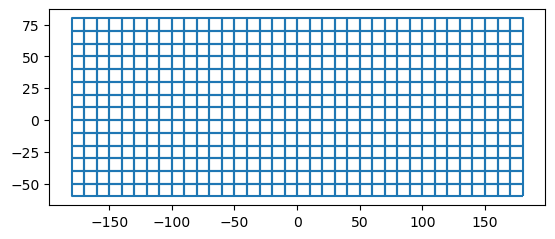

In [3]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/global-surface-water/downloads2020/occurrence'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):d}W'
    else:
        lon_str = f'{abs(lon):d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):d}N'
    else:
        lat_str = f'{abs(lat):d}S'
    return f'{base_url}/occurrence_{lon_str}_{lat_str}v1_3_2020.tif'

df_peckel_data['source_url'] = list(map(url_generator, ul_corners))
df_peckel_data['year'] = 2020
df_peckel_data.boundary.plot()

In [4]:
sample_url = df_peckel_data.source_url[0]
print(sample_url)

https://storage.googleapis.com/global-surface-water/downloads2020/occurrence/occurrence_180W_80Nv1_3_2020.tif


In [5]:
df_peckel_data.to_file('peckel_tiles.geojson', driver='GeoJSON')

In [6]:
with rasterio.open(sample_url) as ds:
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -180.0,
       0.0, -0.00025, 80.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

# Get Peckel Data

In [7]:
def build_peckel_vrt(extent: list, 
                     out_path: Path):
    bbox = box(*extent)
    ind_inter = df_peckel_data.geometry.intersects(bbox)
    df_subset = df_peckel_data[ind_inter].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.source_url.tolist())
    return out_path

def get_peckel_raster(extent:list) -> tuple:
    tmp_vrt = Path('peckel_data_tmp.vrt')
    build_peckel_vrt(extent, tmp_vrt)
    X, p = read_raster_from_window(tmp_vrt,
                                   extent,
                                   CRS.from_epsg(4326))
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

<Axes: >

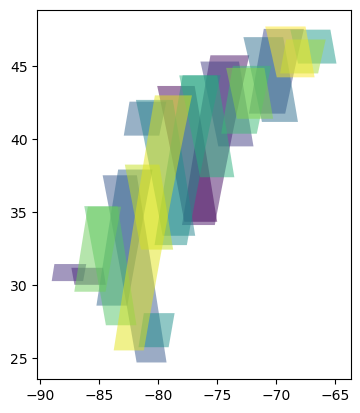

In [8]:
df_aois = gpd.read_file('track-aois.geojson')
df_aois.plot(column='track_number_min',alpha=.5)

In [9]:
sample_aoi = df_aois[df_aois.track_number_min == 77].geometry.unary_union
bounds_4326 = sample_aoi.bounds

In [10]:
%%time

X_occ, p_occ = get_peckel_raster(list(bounds_4326))

CPU times: user 4.63 s, sys: 8.94 s, total: 13.6 s
Wall time: 6min 26s


In [15]:
res = p_occ['transform'].a

In [26]:
%%time

p_occ_new = update_profile_resolution(p_occ, res * 3)
X_occ_low_res, _ = reproject_arr_to_match_profile(X_occ, p_occ, p_occ_new, resampling='average')
X_occ_low_res = X_occ_low_res[0, ...]

CPU times: user 3.69 s, sys: 245 ms, total: 3.93 s
Wall time: 3.93 s


In [31]:
WATER_OCCURENCE_THRESHOLD = 95
water_mask = np.zeros(X_occ_low_res.shape, dtype=np.uint8)
water_mask[X_occ_low_res > WATER_OCCURENCE_THRESHOLD] = 1

In [32]:
%%time

with rasterio.open(f'pekel_water_mask.tif', 'w', **p_occ_new) as ds:
    ds.write(water_mask, 1)

CPU times: user 42.9 ms, sys: 30.7 ms, total: 73.6 ms
Wall time: 71.8 ms
